In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [438]:
names_prods = ['Saving Accounts', 'Guarantees', 'Current Accounts', 'Derivada Account', 'Payroll Account', 'Junior Account',
               'Más particular Account', 'Particular Account', 'Particular Plus Account', 'Short-term deposits',
               'Medium-term deposits', 'Long-term deposits', 'e-account', 'Funds', 'Mortgage', 'Pensions', 'Loans', 'Taxes',
               'Credit Card', 'Securities', 'Home Account', 'Payroll', 'Pensions', 'Direct Debit']

### Carga de datos de entrenamiento y test

In [2]:
%%time
df = pd.read_csv('data/train_ver2.csv',
                 dtype={'sexo': str, 'age': str, 'ind_nuevo': str, 'indrel_1mes': str, 
                        'antiguedad': str, 'ult_fec_cli_lt': str, 'indext': str, 'conyuemp': str},
                 parse_dates=['fecha_dato', 'fecha_alta'])
df.head()

CPU times: user 1min 11s, sys: 4.6 s, total: 1min 16s
Wall time: 1min 16s


In [3]:
%%time
df_test = pd.read_csv('data/test_ver2.csv',
                 dtype={'sexo': str, 'age': str, 'ind_nuevo': str, 'indrel_1mes': str, 
                        'antiguedad': str, 'ult_fec_cli_lt': str, 'indext': str, 'conyuemp': str},
                 parse_dates=['fecha_dato', 'fecha_alta'])
df_test.head()

CPU times: user 4.04 s, sys: 16 ms, total: 4.05 s
Wall time: 4.05 s


In [4]:
df.shape, df_test.shape

((13647309, 48), (929615, 24))

### Exploración de productos por mes

In [23]:
products = df.loc[:, ['fecha_dato']].join(df.loc[:, 'ind_ahor_fin_ult1':])

In [24]:
products.shape

(13647309, 25)

##### Cantidad de productos cada mes

In [67]:
df_a = products.groupby(['fecha_dato']).sum()

In [70]:
df_a.head()

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
fecha_dato,,,,,,,,,,,,,,,,,,,,,
2015-01-28,88,19,487855,301,58763,7757,8418,106471,36195,1513,...,5007,7430,2349,38288,35613,20263,3234,38995.0,43331.0,95601
2015-02-28,89,20,488658,301,60028,7690,8228,106043,36040,2055,...,4998,7407,2344,38507,34352,20198,3219,40746.0,44810.0,94543
2015-03-28,89,21,489074,315,60929,7674,7875,105688,35847,2396,...,4988,7384,2340,38727,34990,20020,3196,42967.0,44109.0,97211
2015-04-28,87,21,489069,313,62221,7653,7482,105167,35650,2439,...,4968,7370,2346,39603,35988,19939,3173,42443.0,46593.0,98312
2015-05-28,85,21,489737,313,63391,7647,7096,104947,35499,2075,...,4797,7363,2342,39946,35880,19955,3155,41383.0,42458.0,96487


In [478]:
#Descripción de los productos
descr_prods = {}
for i, p in enumerate(names_prods):
    descr_prods[df_a.columns.tolist()[i]] = { 'num': str(i), 'name': p }

In [376]:
dates = [d.strftime("%b %Y") for d in df_a.index]

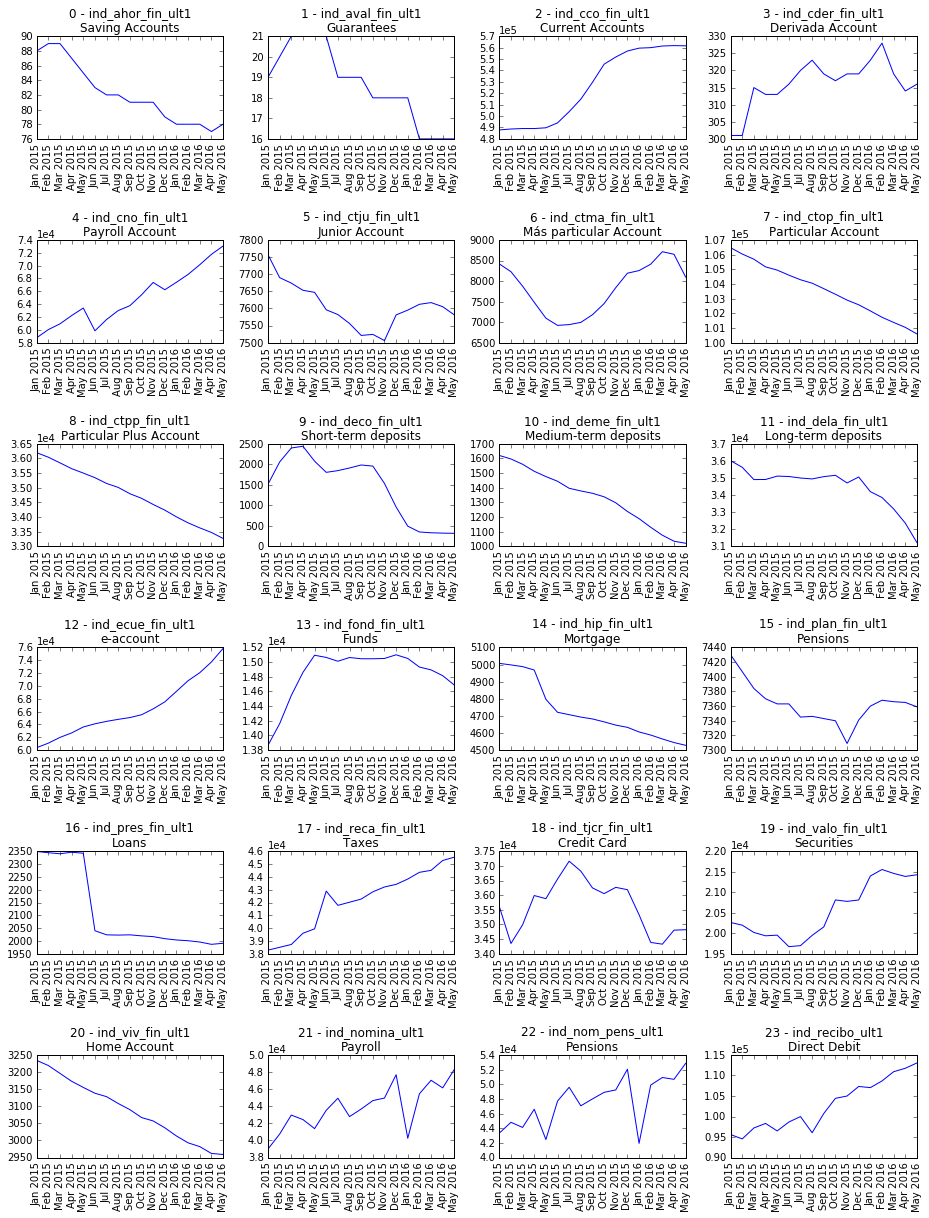

In [479]:
fig, axes = plt.subplots(6, 4, sharex=False, figsize=(13, 17))
axs = [j for i in axes for j in i]
for i, col in enumerate(df_a.columns):
    serie = df_a.loc[:, col]
    ax = axs[i]
    ax.plot(serie.values)
    ax.set_title(descr_prods[col]['num'] + " - " + str(col) + '\n' + descr_prods[col]['name'])
    ax.set_xticks(range(len(dates)))
    ax.set_xticklabels(dates, rotation=90)
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 4))
plt.tight_layout(h_pad=2)

### Compras y "abandonos" de productos por mes
En esta sección se mira el comportamiento de compra y abandono de cada producto por mes

In [318]:
df_b = pd.DataFrame(columns=df_a.columns.tolist()[0:]) #dataframe products prev bought
for i in range(1, len(dates)):
    prev_prods = df_a.loc[df_a.index[i-1]].as_matrix()
    act_prods = df_a.loc[df_a.index[i]].as_matrix()
    bought_prods = act_prods - prev_prods
    df_b.loc[i] = bought_prods

In [319]:
df_b = df_a.reset_index().loc[:, ['fecha_dato']].join(df_b).iloc[1:]
df_b = df_b.set_index('fecha_dato')

In [465]:
df_b

,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
fecha_dato,,,,,,,,,,,,,,,,,,,,,
2015-02-28,1.0,1.0,803.0,0.0,1265.0,-67.0,-190.0,-428.0,-155.0,542.0,...,-9.0,-23.0,-5.0,219.0,-1261.0,-65.0,-15.0,1751.0,1479.0,-1058.0
2015-03-28,0.0,1.0,416.0,14.0,901.0,-16.0,-353.0,-355.0,-193.0,341.0,...,-10.0,-23.0,-4.0,220.0,638.0,-178.0,-23.0,2221.0,-701.0,2668.0
2015-04-28,-2.0,0.0,-5.0,-2.0,1292.0,-21.0,-393.0,-521.0,-197.0,43.0,...,-20.0,-14.0,6.0,876.0,998.0,-81.0,-23.0,-524.0,2484.0,1101.0
2015-05-28,-2.0,0.0,668.0,0.0,1170.0,-6.0,-386.0,-220.0,-151.0,-364.0,...,-171.0,-7.0,-4.0,343.0,-108.0,16.0,-18.0,-1060.0,-4135.0,-1825.0
2015-06-28,-2.0,0.0,4290.0,3.0,-3546.0,-51.0,-176.0,-345.0,-157.0,-272.0,...,-76.0,0.0,-302.0,2942.0,670.0,-280.0,-17.0,2141.0,5245.0,2168.0
2015-07-28,-1.0,-2.0,9876.0,4.0,1762.0,-14.0,19.0,-314.0,-197.0,42.0,...,-14.0,-18.0,-16.0,-1109.0,609.0,24.0,-10.0,1413.0,1886.0,1326.0
2015-08-28,0.0,0.0,10924.0,3.0,1390.0,-26.0,54.0,-235.0,-135.0,64.0,...,-14.0,1.0,-1.0,242.0,-339.0,250.0,-20.0,-2149.0,-2529.0,-3936.0
2015-09-28,-1.0,0.0,14781.0,-4.0,762.0,-35.0,187.0,-373.0,-215.0,73.0,...,-11.0,-3.0,1.0,246.0,-572.0,206.0,-18.0,885.0,938.0,4681.0
2015-10-28,0.0,-1.0,15908.0,-2.0,1690.0,3.0,271.0,-381.0,-156.0,-27.0,...,-17.0,-3.0,-4.0,565.0,-195.0,658.0,-23.0,984.0,898.0,3701.0


In [ ]:
fig, axes = plt.subplots(6, 4, sharex=False, figsize=(13, 17))
axs = [j for i in axes for j in i]
for i, col in enumerate(df_b.columns):
    serie = df_b.loc[:, col]
    ax = axs[i]
    ax.plot(serie.values, c='r')
    ax.set_title(descr_prods[col]['num'] + " - " + str(col) + '\n' + descr_prods[col]['name'])
    ax.set_xticks(range(len(dates[1:])))
    ax.set_xticklabels(dates[1:], rotation=90)
    ax.axhline()
    ax.grid()
    #ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 4))
plt.tight_layout(h_pad=2)

In [357]:
top_products = [i for i in reversed(df_a.mean().sort_values()[-9:].index)]

In [ ]:
fig, axes = plt.subplots(3, 3, sharex=False, figsize=(13, 10))
axs = [j for i in axes for j in i]
for i, col in enumerate(top_products):
    serie = df_a.loc[:, col]
    ax = axs[i]
    ax.plot(serie.values, linewidth=1.3, c='c')
    ax.set_title(descr_prods[col]['num'] + " - " + str(col) + '\n' + descr_prods[col]['name'])
    ax.set_xticks(range(len(dates)))
    ax.set_xticklabels(dates, rotation=90)
    #ax.axhline()
    ax.grid()
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 4))
plt.tight_layout(h_pad=2)

In [460]:
df_a.loc[df.fecha_dato.value_counts().index[0], 'ind_cco_fin_ult1'] / df.fecha_dato.value_counts()[0]

0.60294507613373949